In [0]:
import torch 
import torch.nn as nn
import torch.optim as optim

import torchvision 
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
# for reproducibility 

torch.manual_seed(777)

if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [0]:
# parameters 

lr = 0.001
training_epochs = 100
batch_size = 512

In [0]:
# set data transformation
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [6]:
# get cifar 10 data
trainset = dsets.CIFAR10(root='./cifar10', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
testset = dsets.CIFAR10(root='./cifar10', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170221568/170498071 [00:40<00:00, 5741085.27it/s]

Files already downloaded and verified


In [53]:
model_sample = torchvision.models.vgg11()
model_sample

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [0]:
class VGG_model(torch.nn.Module):
  def __init__(self, n_classes, init_weights=True):
    super(VGG_model, self).__init__()
    
    self.features = nn.Sequential(
        # 32, 32, 3 => 32, 32, 64 => 16, 16, 64
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # 16, 16, 64 => 16, 16, 128 => 8, 8, 128
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # 8, 8, 128 => 8, 8, 256
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # 8, 8, 256 => 8, 8, 256 => 4, 4, 256
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # 4, 4, 256 => 4, 4, 512
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # 4, 4, 512 => 4, 4, 512 => 2, 2, 512
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # 2, 2, 512 => 2, 2, 512
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # 2, 2, 512 => 2, 2, 512 => 1, 1, 512
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.avgpool = nn.AdaptiveAvgPool2d((7,7))
    
    self.classifier = nn.Sequential(
        nn.Linear(7*7*512, 4096, bias=True),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096, bias=True),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, n_classes, bias=True))
  
  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return(x)
  
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [0]:
model = VGG_model(n_classes=10).to(device)

In [21]:
a=torch.Tensor(1,3,32,32).to(device)
out = model(a)
print(out)

tensor([[ 7.0766e+32, -1.2680e+34, -1.0661e+33,  5.1315e+33,  3.5442e+33,
         -1.5667e+33, -7.0511e+33, -1.3496e+34, -6.0009e+32,  1.5665e+34]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [22]:
model

VGG_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddi

In [0]:
# set loss functions and optimizers 
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [0]:
hist_step = []
hist_loss = []

In [0]:
total_batch = len(trainloader)

In [26]:
print('Training Starts')
for epoch in range(training_epochs):
  avg_cost = 0
  
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    hypothesis = model(inputs)
    cost = criterion(hypothesis, labels)
    cost.backward()
    optimizer.step()
    
    avg_cost += cost / total_batch
    
  hist_step.append(epoch+1)
  hist_loss.append(avg_cost)
  
  print('[Epoch {}] Cost= {:.9f}'.format(epoch+1, avg_cost))
  
print('Training Complete')

Training Starts
[Epoch 1] Cost= 2.137908220
[Epoch 2] Cost= 1.843970299
[Epoch 3] Cost= 1.554097176
[Epoch 4] Cost= 1.282624245
[Epoch 5] Cost= 1.065647483
[Epoch 6] Cost= 0.945055068
[Epoch 7] Cost= 0.802863777
[Epoch 8] Cost= 0.715247571
[Epoch 9] Cost= 0.639183402
[Epoch 10] Cost= 0.548346817
[Epoch 11] Cost= 0.478608876
[Epoch 12] Cost= 0.398096114
[Epoch 13] Cost= 0.345737100
[Epoch 14] Cost= 0.287862897
[Epoch 15] Cost= 0.252154231
[Epoch 16] Cost= 0.228731245
[Epoch 17] Cost= 0.200214952
[Epoch 18] Cost= 0.168604657
[Epoch 19] Cost= 0.145767078
[Epoch 20] Cost= 0.125543386
[Epoch 21] Cost= 0.129582837
[Epoch 22] Cost= 0.113859497
[Epoch 23] Cost= 0.099208839
[Epoch 24] Cost= 0.093391150
[Epoch 25] Cost= 0.087525710
[Epoch 26] Cost= 0.088730201
[Epoch 27] Cost= 0.076993540
[Epoch 28] Cost= 0.071071126
[Epoch 29] Cost= 0.072732463
[Epoch 30] Cost= 0.067847416
[Epoch 31] Cost= 0.062182765
[Epoch 32] Cost= 0.070833981
[Epoch 33] Cost= 0.067712419
[Epoch 34] Cost= 0.059826594
[Epoch 

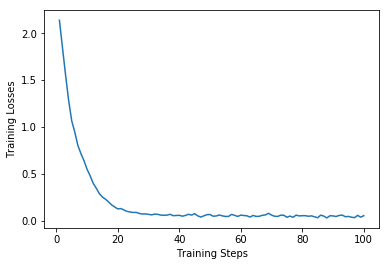

In [27]:
plt.plot(hist_step, hist_loss)
plt.xlabel('Training Steps')
plt.ylabel('Training Losses')
plt.show()

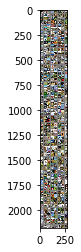

GroundTruth:    dog truck  ship plane


In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
images = images.to(device)
labels = labels.to(device)

outputs = model(images).to(device)

In [37]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat truck  ship plane


In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %
